In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from arps.dca import (
      hyperbolic_equation, 
      get_min_or_max_value_in_column_by_group,
      get_max_initial_production,
      plot_actual_vs_predicted_by_equations,
      remove_nan_and_zeroes_from_columns
)
from arps.fit_arps import execute_arps
df = pd.read_csv("recoil_daily_prod.csv")
df = df.astype({"API": str,'OIL (BBL)':float})
df = df[(df['OIL (BBL)'].notnull()) & (df['OIL (BBL)']>0)]
df['days'] = df.groupby('API').cumcount()+1

[[Model]]
    Model(hyperbolic_equation)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 125
    # data points      = 2251
    # variables        = 3
    chi-square         = 912012.741
    reduced chi-square = 405.699618
    Akaike info crit   = 13521.6329
    Bayesian info crit = 13538.7903
[[Variables]]
    qi:  232.191630 +/- 3.76946051 (1.62%) (init = 1000)
    b:   0.67128788 +/- 0.03080838 (4.59%) (init = 3)
    di:  0.00565920 +/- 2.5839e-04 (4.57%) (init = 0.8)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, di)  =  0.873
    C(qi, di) =  0.829
    C(qi, b)  =  0.573
R-Square:  0.8085232944149098
EUR: 98637.23475690119 BBL


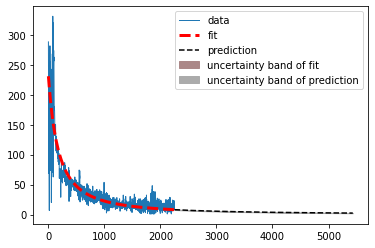

In [52]:
import numpy as np
from lmfit import Model
import matplotlib.pyplot as plt
from arps.dca import hyperbolic_equation

filtered_df = df[df.API=='42493327380000']

cumsum_days = filtered_df['days']
prod = filtered_df['OIL (BBL)']

# plot data
plt.plot(cumsum_days, prod,label='data',linewidth=1)

# build Model
hmodel = Model(hyperbolic_equation)

# create lmfit Parameters, named from the arguments of `hyperbolic_equation`
# note that you really must provide initial values.
#params = hmodel.make_params(qi=431.0371968722894, b=0.5443981508109322, di=0.006643764565975722)

params = hmodel.make_params(qi=1000, b=3, di=.8)



# set bounds on parameters
params['qi'].min=0
params['b'].min=0.5
params['di'].min=0

# do fit, print resulting parameters
result = hmodel.fit(prod, params, t=cumsum_days)

y = prod
y_fit = result.best_fit

ss_res = np.sum((y - y_fit) ** 2)
# total sum of squares
ss_tot = np.sum((y - np.mean(y)) ** 2)
# r-squared
r2 = 1 - (ss_res / ss_tot)
print(result.fit_report())
print("R-Square: ",r2)

# plot best fit: not that great of fit, really
plt.plot(cumsum_days, result.best_fit, 'r--', label='fit',linewidth=3)

# calculate the (1 sigma) uncertainty in the predicted model
# and plot that as a confidence band
dprod = result.eval_uncertainty(result.params, sigma=10)   
plt.fill_between(cumsum_days,
                 result.best_fit-dprod,
                 result.best_fit+dprod,
                 color="#AB8888",
                 label='uncertainty band of fit')

# now evaluate the model for other values, predicting future values
future_days = np.array(np.arange(max(cumsum_days+1),2434+3000))
future_prod = result.eval(t=future_days)
eur = sum(prod)+sum(future_prod)

plt.plot(future_days, future_prod, 'k--', label='prediction')

# ...and calculate the 1-sigma uncertainty in the future prediction
# for 95% confidence level, you'd want to use `sigma=2` here:
future_dprod = result.eval_uncertainty(t=future_days, sigma=1)

#print("### Prediction\n# Day  Prod     Uncertainty")

# for day, prod, eps in zip(future_days, future_prod, future_dprod):
#     print(" {:.1f}   {:.1f} +/- {:.1f}".format(day, prod, eps))

plt.fill_between(future_days,
                 future_prod-future_dprod,
                 future_prod+future_dprod,
                 color="#ABABAB",
                 label='uncertainty band of prediction')

plt.legend(loc='upper right')
print("EUR:", eur,"BBL")
plt.show()